In [1]:
# Import Libaries

import numpy as np
import pandas as pd 
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
matplotlib.rcParams['figure.figsize']= (12,8) # Adjust the configuraton of the plots we will create 


In [2]:
# Read the data 
df = pd.read_csv('movies.csv')
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


### Data Cleaning

In [3]:
# Checking data types 
df.dtypes

name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

In [4]:
df.isnull().sum()

name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64

In [5]:
# Checking for missing data (C1)

for col in df.columns:
    pct_missing = np.mean(df[col].isnull()) # Select rows whose column value is null
    print('{} - {}%'.format(col, round(pct_missing*100)))

name - 0%
rating - 1%
genre - 0%
year - 0%
released - 0%
score - 0%
votes - 0%
director - 0%
writer - 0%
star - 0%
country - 0%
budget - 28%
gross - 2%
company - 0%
runtime - 0%


<AxesSubplot:>

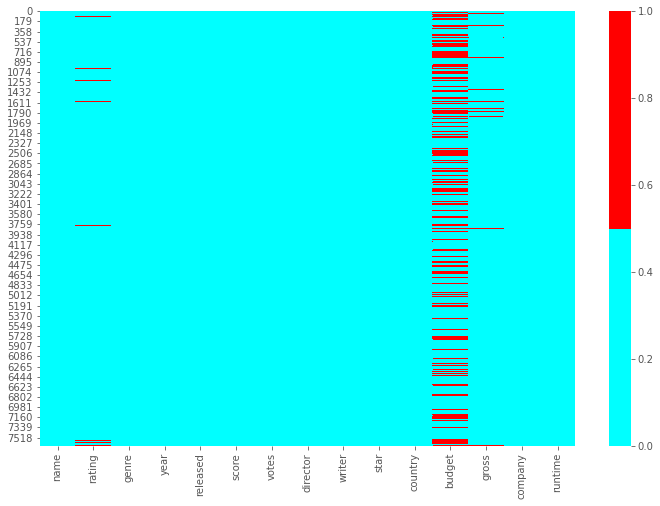

In [6]:
# Visualizing missing data 

cols = df.columns[:] # Return column labels of the given dataframe
colors = ['cyan','red'] # Cyan is missing data. Red is not missing data

sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

<AxesSubplot:>

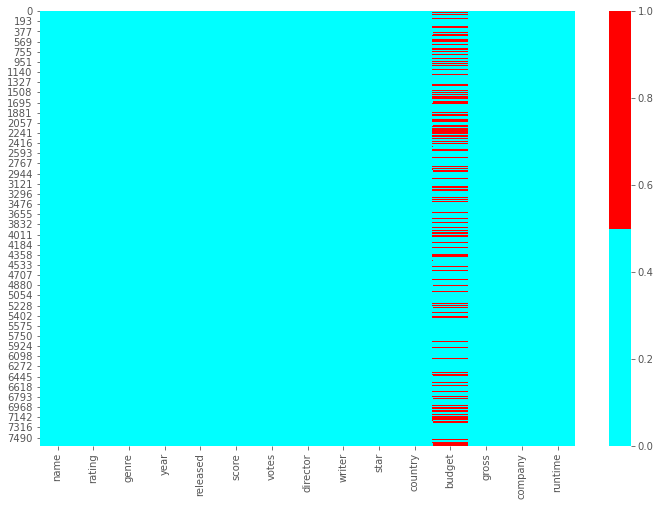

In [7]:
# Because the amout of missing data in rating and gross is only 1% and 2% respectively
# So delete all the rows with missing data in rating and gross columns
# Also remove all the rows with very little missing data in other columns except budget

df_no_missing = df.dropna(subset=['name','rating','genre','year','released','score','votes','director','writer','star','country','gross','company','runtime'])

# Keep missing values in budget because it's quite a lot (28%)
# Visualizing new dataframe which removed rows with missing data

cols = df_no_missing.columns[:]
colors = ['cyan','red']
sns.heatmap(df_no_missing[cols].isnull(), cmap =sns.color_palette(colors))

In [8]:
# Checking for duplicate data (C1)
duplicateRowsDF = df_no_missing[df_no_missing.duplicated(keep=False)]
duplicateRowsDF

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime


## Data Visualization

### Budget vs Gross

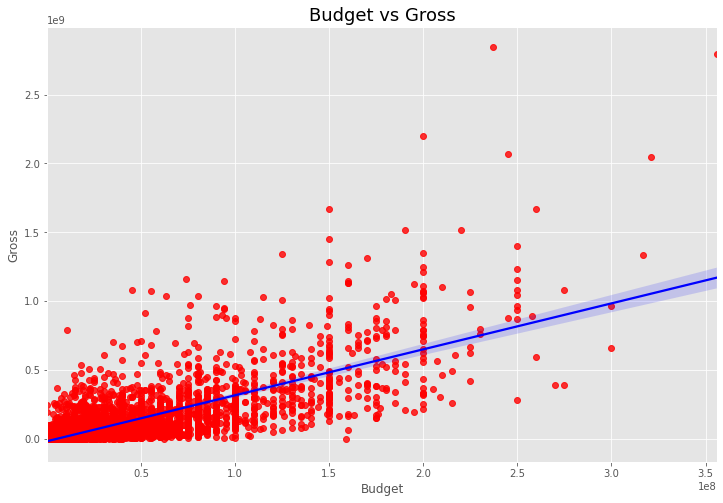

In [9]:
# Plot budget vs gross using seaborn
sns.regplot(x='budget',y='gross', data=df_no_missing,scatter_kws={"color":"red"}, line_kws={"color":"blue"})

plt.title('Budget vs Gross',fontsize = 18)
plt.xlabel('Budget')
plt.ylabel('Gross')

plt.show() 

In [10]:
# Looking at correlation
df_no_missing.corr() 

,year,score,votes,budget,gross,runtime
year,1.000000,0.093951,0.218941,0.327722,0.258826,0.114237
score,0.093951,1.000000,0.415190,0.072001,0.188071,0.397226
votes,0.218941,0.415190,1.000000,0.439675,0.631110,0.309945
budget,0.327722,0.072001,0.439675,1.000000,0.740247,0.318695
gross,0.258826,0.188071,0.631110,0.740247,1.000000,0.245117
runtime,0.114237,0.397226,0.309945,0.318695,0.245117,1.000000


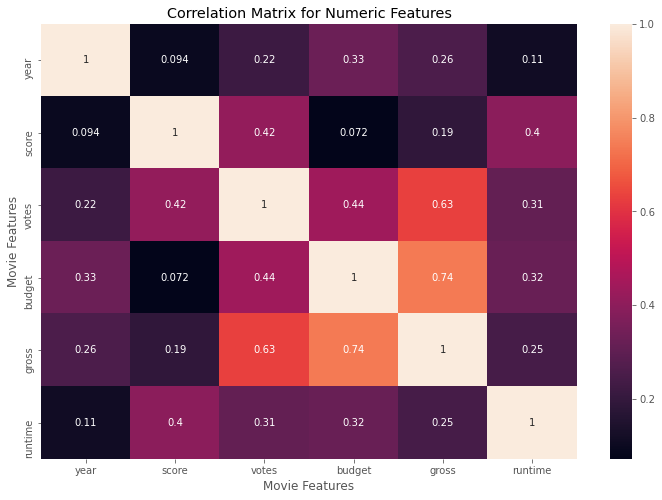

In [11]:
# Visualize the correlation matrix
correlation_matrix = df_no_missing.corr()

sns.heatmap(correlation_matrix, annot=True) 

plt.title('Correlation Matrix for Numeric Features')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')

plt.show() 

### Gross vs Votes

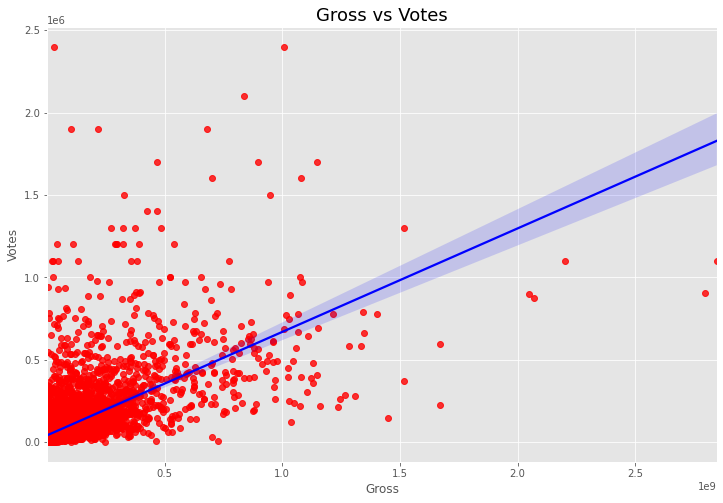

In [12]:
# Plot gross and votes using seaborn
sns.regplot(x='gross',y='votes', data=df_no_missing,scatter_kws={"color":"red"}, line_kws={"color":"blue"})

plt.title('Gross vs Votes',fontsize = 18)
plt.xlabel('Gross')
plt.ylabel('Votes')

plt.show() 

### Genre
Genre of a movie could affect its success depending on what genre is trending

In [13]:
# Sort genre by movie counts
genre = df.groupby(['genre']).size().sort_values(ascending=False).reset_index()
genre.columns = ['genre','count']

# Group last 10 genres as 'Others' because each of them has only less than 50
others = genre.loc[list(range(8,19))]['count'].sum()

# Drop rows from 8-18
genre = genre.drop(list(range(8,19)))

# Insert genre 'Others'
genre.loc[8] = ['Others',others]

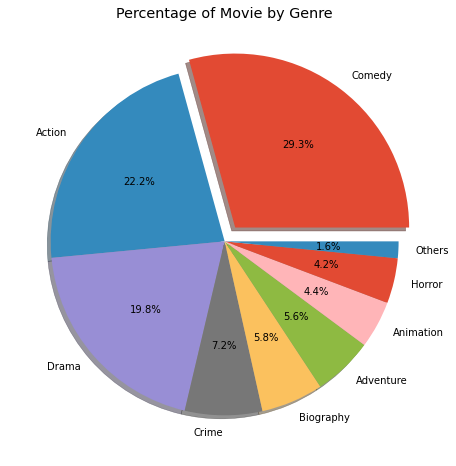

In [14]:
# Genre pie chart

labels = genre['genre']
size = genre['count']
plt.title('Percentage of Movie by Genre')

plt.pie(size, labels = labels, explode=[0.1,0,0,0,0,0,0,0,0], autopct='%0.1f%%',shadow=True)

plt.show()

### Countries vs Number of Movies Released

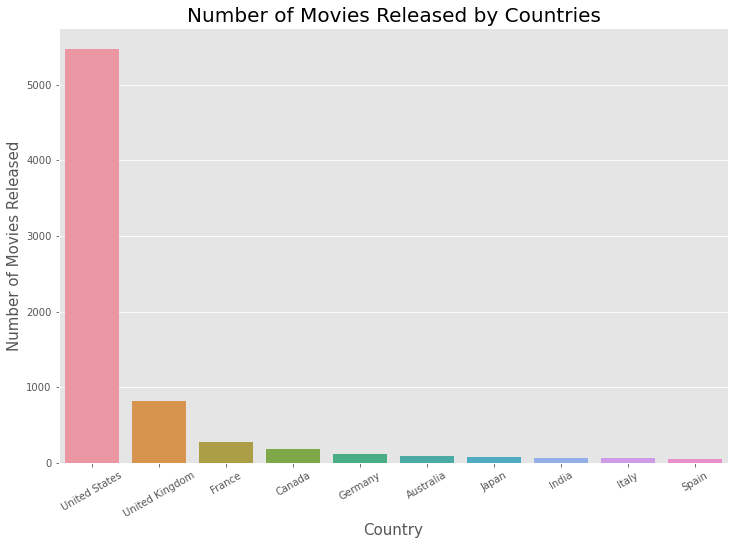

In [15]:
top_countries = df['country'].value_counts().head(10).reset_index()

# Number of Movies Released by Countries
sns.barplot(x = top_countries['index'], y=top_countries['country'])

plt.title('Number of Movies Released by Countries', fontsize=20)
plt.xlabel('Country', fontsize=15)
plt.ylabel('Number of Movies Released', fontsize=15)
plt.xticks(list(range(10)), top_countries['index'], rotation = 30)

plt.show()

### Movies Director

In [16]:
directors = df['director'].value_counts().reset_index()
directors.columns  = ['director','frequency']
directors

,director,frequency
0,Woody Allen,38
1,Clint Eastwood,31
2,Directors,28
3,Steven Spielberg,27
4,Ron Howard,24
...,...,...
2944,Wolf Gremm,1
2945,Marc Schölermann,1
2946,Yarrow Cheney,1
2947,John Hoffman,1


In [17]:
# Remove "Directors" out of director columns
df = df.drop(index=df[df['director'] == 'Directors'].index)

In [18]:
directors = df['director'].value_counts().reset_index()
directors.columns  = ['director','frequency']
directors.head(10)

,director,frequency
0,Woody Allen,38
1,Clint Eastwood,31
2,Steven Spielberg,27
3,Ron Howard,24
4,Steven Soderbergh,23
5,Ridley Scott,23
6,Joel Schumacher,22
7,Barry Levinson,20
8,Martin Scorsese,19
9,Tim Burton,19


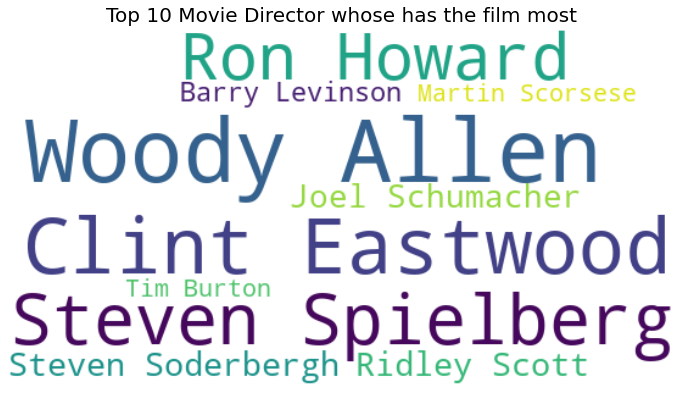

In [19]:
# Create word cloud chart for Top 10 Movie Director whose has the film most
words = dict()
for i in range(10):
    words[directors['director'][i]] = directors['frequency'][i]
    
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=100,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)

plt.title('Top 10 Movie Director whose has the film most',fontsize=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

In [20]:
# Movie directors vs Net
df['net'] = df['gross']-df['budget']
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,net
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,27998772.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,54353106.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,520375067.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,79953539.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,33846344.0


In [21]:
directors_net = df.groupby(['director']).net.mean().sort_values(ascending=False).head(10).reset_index()
directors_net

,director,net
0,Anthony Russo,1.138650e+09
1,Kyle Balda,1.020122e+09
2,Chris Buck,9.165756e+08
3,Josh Cooley,8.733946e+08
4,Joss Whedon,8.176901e+08
5,James Cameron,7.855984e+08
6,Lee Unkrich,7.498943e+08
7,George Lucas,7.354177e+08
8,Pierre Coffin,6.844400e+08
9,David Yates,6.599247e+08


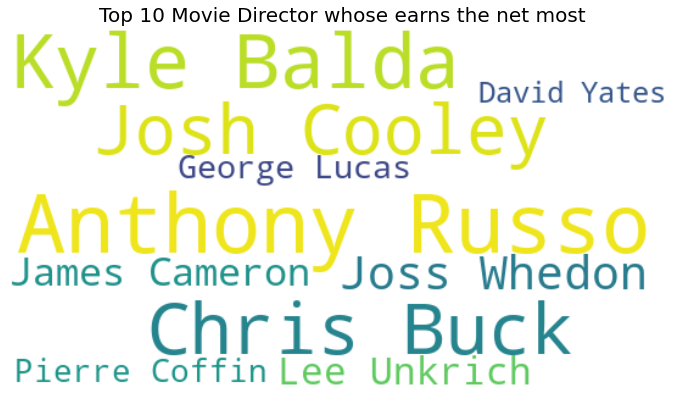

In [22]:
# Create word cloud chart for Top 10 Movie Director whose earns the net most
words = dict()
for i in range(10):
    words[directors_net['director'][i]] = directors_net['net'][i]
    
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=100,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)

plt.title('Top 10 Movie Director whose earns the net most',fontsize=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

<ipython-input-23-19ed331ccb27>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabel)


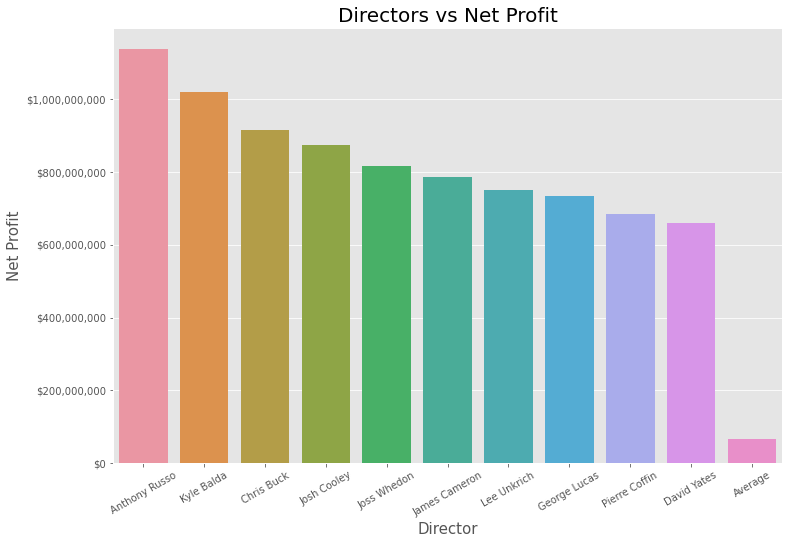

In [23]:
# Compare between the net profit of Top 10 Movie Director and Average net profit of all Movies Directors
directors_net.loc[10] = ['Average', df['net'].mean()]

ax = sns.barplot(x = directors_net['director'], y = directors_net['net'])

plt.title('Directors vs Net Profit', fontsize = 20)
plt.xlabel('Director', fontsize = 15)
plt.ylabel('Net Profit', fontsize = 15)

plt.xticks(list(range(11)), directors_net['director'], rotation = 30)
ticks = ax.get_yticks()
ylabel = ['$' + '{:,.0f}'.format(x) for x in ticks]
ax.set_yticklabels(ylabel)

plt.show()

### Actors

In [24]:
actor = df.groupby(['star']).net.sum().sort_values(ascending=False).head(10).reset_index()
actor.columns = ['actor', 'net']

# Average profit of the movies with top 10 actors
actor['net'].mean()

# Average sum of profit of all actors
df.groupby(['star']).net.sum().sort_values(ascending=False).reset_index()['net'].mean()

# Adding average data points 
actor.loc[10] = ['Average (Top 10 Actors)', actor['net'].mean()]

actor.loc[11] = ['Average (Of All Movies)', df.groupby(['star']).net.sum().sort_values(ascending=False).reset_index()['net'].mean()]

<ipython-input-25-ecb3b65c81c1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabel)


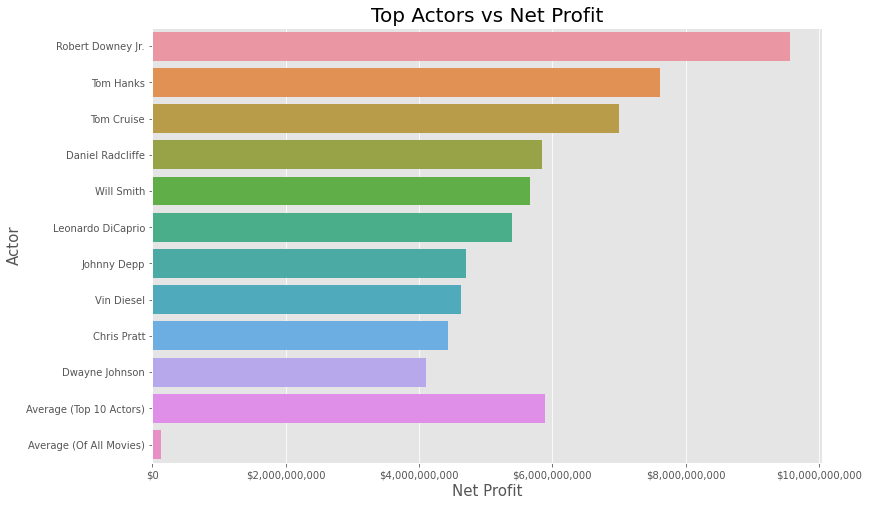

In [25]:
# Create bar chart for Top Actors vs Net Profit
ax = sns.barplot(x = actor['net'], y = actor['actor'])

plt.title('Top Actors vs Net Profit', fontsize = 20)
plt.xlabel('Net Profit', fontsize = 15)
plt.ylabel('Actor', fontsize = 15)

plt.yticks(list(range(12)), actor['actor'], rotation = 0)
ticks = ax.get_xticks()
xlabel = ['$' + '{:,.0f}'.format(x) for x in ticks]
ax.set_xticklabels(xlabel)

plt.show()